## To do list:

* Run model without soil moisture or bulk EC (this will add Shale Hills data to the model)
* There is a very strange error in the code where the depth column in df_out can't be accessed via slicing with ==, but it can be accessed by slicing with >= or <=. When I first made the code it ran fine, but upon restarting I can't get the == slicing to work. I APPEAR TO HAVE FIXED THIS PROBLEM BY GETTING DEPTH A DIFFERENT WAY, BUT I STILL DON'T KNOW WHY IT DIDN'T WORK IN THE FIRST PLACE
* Nearest neighbors interpolation takes a really long time (ran it overnight and it didn't finish), so I'm going to try and parallelize

## Possible ways to improve model performance

* Add atmospheric CO2
* Apply your better spike removal code to the other sites
* Try the interpolated precip from PRISM
* Try random forest model



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive 
# list of all potential features across all pits
features = ['CO2', 'timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 
            'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site', 'Season']
m = len(features)

# Define site and pit number indices
site_nos = {'Calhoun': 0, 'Shale_Hills': 2, 
            'Catalina-Jemez': 1, 'Seca_Floresta': 3}
pit_nos = {}
i = 0
for site, pits in all_pits.items():
    for pit in pits:
        pit_nos[pit] = i
        i += 1
        
# Remove pits with manual samples
del all_pits['Seca_Floresta']
all_pits['Calhoun'].remove('R1C2')
all_pits['Shale_Hills'].remove('SPMS')

In [2]:
total_count = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        with open(infile) as f:
            for i, l in enumerate(f):
                pass
        nlines = i + 1
        total_count += nlines
        print(site, pit, '--', nlines)
print(total_count)

Calhoun R1C1 -- 28388
Calhoun R1H1 -- 28394
Calhoun R1P1 -- 28393
Catalina-Jemez BGZOB1 -- 27277
Catalina-Jemez BGZOB2 -- 27302
Catalina-Jemez BGZOB3 -- 27297
Catalina-Jemez BGZOB4 -- 27275
Catalina-Jemez Green1 -- 27976
Catalina-Jemez Green2 -- 6995
Catalina-Jemez Green3 -- 27975
Catalina-Jemez MC1 -- 72374
Catalina-Jemez MC2 -- 72658
Catalina-Jemez MC3 -- 72539
Catalina-Jemez MC4 -- 72540
Catalina-Jemez MC5 -- 71698
Catalina-Jemez MC6 -- 72539
Shale_Hills LRMS -- 14137
Shale_Hills NPMS -- 34448
Shale_Hills SPVF -- 2999
Shale_Hills TMMS -- 35403
778607


In [3]:
# Load in and merge all files
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        df = pd.read_csv(infile, parse_dates=[0], na_values=[-99999])

        # Remove records without any CO2 data
        co2_cols = [col for col in df.columns if 'CO2' in col]
        df = df[~df.loc[:, co2_cols].isna().all(axis=1)]
        
        depths = []
        for col in df.columns:
            if ('precip' not in col) and ('DateTime' not in col):
                depths.append(col.split('_')[1].split('cm')[0])
        unique_depths = list(set(depths))

        # t is the number of time steps
        t = df.shape[0]

        # data shape is the # of observations (# time points * depths), # features
        cur_data = np.empty((t*len(unique_depths), m))
        cur_data[:] = np.nan

        for i, depth in enumerate(unique_depths):
            depth_cols = [col for col in df.columns if '_%scm' % depth in col]
            for j, feature in enumerate(features):
                # Look for columns with this feature and depth in the name
                if feature == 'precip':
                    col = 'PRISM_precip.mm'
                elif feature == 'timestamp':
                    col = [col for col in df.columns if 'DateTime' in col]
                    col = col[0]
                elif feature == 'Season':
                    col = [col for col in df.columns if 'DateTime' in col]
                    df['quarter'] = df[col[0]].dt.quarter
                    col = 'quarter'
                else:
                    matches = [col for col in depth_cols if feature in col]

                    # Correct for fact that "O2" search returns "CO2" as well
                    if feature == 'O2':
                        matches = [col for col in matches if 'CO2' not in col]

                    if len(matches) > 1:
                        raise ValueError("""More than one possible match found for 
                        %s %s %scm %s""" %(site, pit, depth, feature))
                    elif len(matches) == 1:
                        col = matches[0]
                    else:
                        col = ""
                        continue
    
                # Now that we have the column name, add this subset to cur_data
                cur_data[i*t:(i+1)*t, j] = df[col].values

            # Add in depth
            cur_data[i*t:(i+1)*t, features.index('Depth')] = depth
        
        # Add in pit and site indices
        cur_data[:, features.index('Pit')] = pit_nos[pit]
        cur_data[:, features.index('Site')] = site_nos[site]
        
        # Copy current data to dict of all data
        data[pit] = cur_data.copy()

In [4]:
# Merge all data into a single numpy array
for i, (pit, array) in enumerate(data.items()):
    if i == 0:
        merged = array.copy()
    else:
        merged = np.append(merged, array, axis=0)

# Remove rows without any CO2 data
all_rows, _ = merged.shape
merged = merged[~np.isnan(merged[:, 0]), :]
trimmed = all_rows - merged.shape[0]
print(f'Removed {trimmed:,} rows without CO2 data')

df = pd.DataFrame(data=merged, columns=features)

Removed 115,759 rows without CO2 data


In [4]:
outfile = '../../merged_processed_data/MergeProcessedData.csv'
np.savetxt(outfile, merged, fmt='%.4f', delimiter=",")


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
#For the nearest neighbors model, run this cell and all subsequent cells

df.drop(columns=['WaterPotential', 'ReductionPotential'], 
        inplace=True)

df=df.dropna()
df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
6794,13570.00000,1.459382e+18,0.0,0.358000,0.044000,16.70500,19.413019,0.0,50.0,0.0,1.0
6795,13830.00000,1.459386e+18,0.0,0.358000,0.044000,16.77000,19.417373,0.0,50.0,0.0,1.0
6796,14100.00000,1.459390e+18,0.0,0.358000,0.044000,16.83500,19.421726,0.0,50.0,0.0,1.0
6797,14315.00000,1.459393e+18,0.0,0.358000,0.044000,16.89000,19.425410,0.0,50.0,0.0,1.0
6798,14515.00000,1.459397e+18,0.0,0.358000,0.044000,16.94000,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1393070,625.05675,1.514664e+18,0.0,0.098000,0.008333,0.70850,13.778000,16.0,10.0,1.0,4.0
1393071,620.41800,1.514668e+18,0.0,0.098000,0.010000,0.68825,13.777750,16.0,10.0,1.0,4.0
1393072,611.34600,1.514671e+18,0.0,0.098000,0.010000,0.63875,13.780500,16.0,10.0,1.0,4.0
1393073,607.84425,1.514675e+18,0.0,0.098000,0.010000,0.60550,13.774000,16.0,10.0,1.0,4.0


In [714]:
#print(np.unique(df['Depth'].values))
#df_nan_linear=df.copy(deep=True)
#df_nan_linear.SoilMoisture.loc[df_nan_linear.sample(frac=.99).index] = np.nan
#df_nan_linear['SoilMoisture']=df_nan_linear['SoilMoisture'].interpolate(method='linear')
#nan_index=df_nan_linear[df_nan_linear.SoilMoisture.notna()==False]
#not_nan_index=df_nan_linear[df_nan_linear.SoilMoisture.notna()==True]
#df_nan_linear.sample(frac=.9).index

#nan_index

df_nan_linear=df.copy(deep=True)



df_nan_linear.SoilMoisture.loc[df_nan_linear.sample(frac=0.9).index] = np.nan


nan_index=df_nan_linear[df_nan_linear.SoilMoisture.notna()==False]
not_nan_index=df_nan_linear[df_nan_linear.SoilMoisture.notna()==True]
df_nan_linear=df_nan_linear.interpolate(method='linear')
#df_nan_linear=df_nan_linear.SoilMoisture.loc[nan_index.index]
df_nan_linear


,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
1,13570.00000,1.459382e+18,0.00,NaN,0.044,16.70500,19.413019,0.0,50.0,0.0,1.0
2,13830.00000,1.459386e+18,0.00,NaN,0.044,16.77000,19.417373,0.0,50.0,0.0,1.0
3,14100.00000,1.459390e+18,0.00,NaN,0.044,16.83500,19.421726,0.0,50.0,0.0,1.0
4,14315.00000,1.459393e+18,0.00,NaN,0.044,16.89000,19.425410,0.0,50.0,0.0,1.0
5,14515.00000,1.459397e+18,0.00,0.358,0.044,16.94000,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1389047,2293.51950,1.500181e+18,7.05,0.178,0.000,15.29050,12.237500,16.0,30.0,2.0,3.0
1389048,2250.84025,1.500185e+18,7.05,0.178,0.000,15.16400,12.252000,16.0,30.0,2.0,3.0
1389049,2227.83200,1.500188e+18,7.05,0.178,0.000,15.07350,12.249500,16.0,30.0,2.0,3.0
1389050,2204.82800,1.500192e+18,7.05,0.178,0.000,15.01625,12.255750,16.0,30.0,2.0,3.0


0.011360481480069205


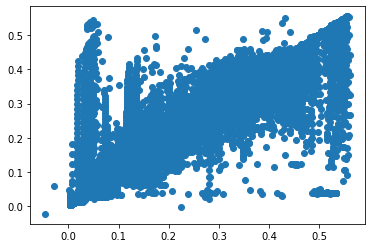

In [715]:
df_nan_linear.SoilMoisture=df_nan_linear.SoilMoisture.fillna(np.nanmedian(df_nan_linear.SoilMoisture))

print(metrics.mean_squared_error(df_nan_linear.SoilMoisture.loc[nan_index.index], df.SoilMoisture.loc[nan_index.index], squared=False))
plt.scatter(df.SoilMoisture.loc[nan_index.index], df_nan_linear.SoilMoisture.loc[nan_index.index])

In [701]:
nan_index

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
1,13570.00000,1.459382e+18,0.00,NaN,0.044,16.70500,19.413019,0.0,50.0,0.0,1.0
2,13830.00000,1.459386e+18,0.00,NaN,0.044,16.77000,19.417373,0.0,50.0,0.0,1.0
3,14100.00000,1.459390e+18,0.00,NaN,0.044,16.83500,19.421726,0.0,50.0,0.0,1.0
4,14315.00000,1.459393e+18,0.00,NaN,0.044,16.89000,19.425410,0.0,50.0,0.0,1.0
5,14515.00000,1.459397e+18,0.00,NaN,0.044,16.94000,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1389046,2334.88050,1.500178e+18,7.05,NaN,0.000,15.43300,12.215500,16.0,30.0,2.0,3.0
1389047,2293.51950,1.500181e+18,7.05,NaN,0.000,15.29050,12.237500,16.0,30.0,2.0,3.0
1389048,2250.84025,1.500185e+18,7.05,NaN,0.000,15.16400,12.252000,16.0,30.0,2.0,3.0
1389050,2204.82800,1.500192e+18,7.05,NaN,0.000,15.01625,12.255750,16.0,30.0,2.0,3.0


In [60]:
#Drop the numerically arbitrary columns when doing PCA, but don't drop for machine learning model (they will be dropped later on)


df['new_index']=list(range(0, len(df)))
df_reindex=df.set_index('new_index')
df=df.drop(columns='new_index')
#df_reindex=df_reindex.drop(columns=['Site', 'Pit', 'Season', 'timestamp'])

df_st =  StandardScaler().fit_transform(df_reindex) 
df_st1=pd.DataFrame(data=df_st)
df_st1

,0,1,2,3,4,5,6,7,8,9,10
0,2.326368,-0.054230,-0.366206,1.892727,0.162984,1.426459,0.773260,-2.166861,0.432495,-5.498728,-1.405168
1,2.393383,-0.054134,-0.366206,1.892727,0.162984,1.438441,0.774392,-2.166861,0.432495,-5.498728,-1.405168
2,2.462976,-0.054039,-0.366206,1.892727,0.162984,1.450422,0.775524,-2.166861,0.432495,-5.498728,-1.405168
3,2.518393,-0.053944,-0.366206,1.892727,0.162984,1.460560,0.776482,-2.166861,0.432495,-5.498728,-1.405168
4,2.569944,-0.053848,-0.366206,1.892727,0.162984,1.469777,0.777353,-2.166861,0.432495,-5.498728,-1.405168
...,...,...,...,...,...,...,...,...,...,...,...
837495,-0.580169,1.027280,1.050904,-0.133352,-0.876770,1.165726,-1.092682,1.775900,-0.336827,0.181860,0.396739
837496,-0.591170,1.027375,1.050904,-0.133352,-0.876770,1.142408,-1.088912,1.775900,-0.336827,0.181860,0.396739
837497,-0.597100,1.027470,1.050904,-0.138980,-0.876770,1.125726,-1.089562,1.775900,-0.336827,0.181860,0.396739
837498,-0.603029,1.027566,1.050904,-0.144608,-0.876770,1.115173,-1.087936,1.775900,-0.336827,0.181860,0.396739


In [10]:
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
df_st_transform
df_st=df_st[df_st_transform[:,0]<=14]
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
len(df_st[:,0])

837494

In [11]:

pca.explained_variance_ratio_


array([0.28405118, 0.22108901, 0.14464826, 0.12069703, 0.08463448,
       0.0807914 , 0.06408863])

In [12]:
pca_out=pca
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_reindex.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
CO2,0.241354,0.619684,-0.031393,0.165358,-0.423012,0.282339,0.520343
precip,0.125367,0.164747,0.871713,-0.432744,0.098795,0.011568,0.009800
SoilMoisture,0.575072,-0.037753,-0.032966,-0.056638,-0.551306,-0.123804,-0.586776
BulkEC,0.483864,-0.153441,0.066978,0.335544,0.457918,0.634105,-0.116093
Temp,-0.081720,0.625856,0.094184,0.459464,0.321539,-0.344597,-0.399393
O2,-0.538792,0.210973,-0.023238,-0.164380,-0.210246,0.619664,-0.457653
Depth,0.253424,0.357317,-0.473442,-0.656859,0.387406,0.001939,-0.049015


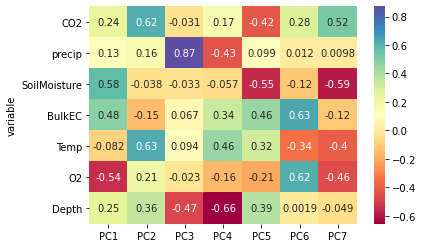

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

<Figure size 432x288 with 0 Axes>

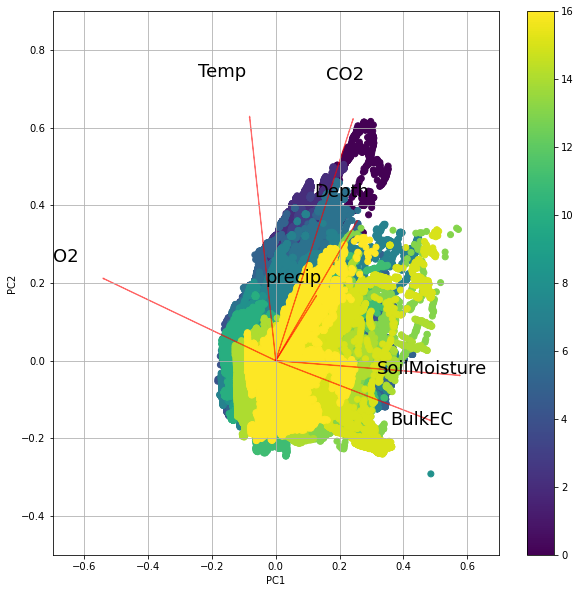

In [14]:
#PCA colored by pit

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig=plt.gcf()
    plt.figure(figsize=(10,10))
    plt.scatter(xs * scalex,ys * scaley, c = df.Pit[0:len(df_st)])#df_st[:,6])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df_reindex.columns.values[i], color = 'k', ha = 'right', va = 'bottom', fontsize=18)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

<Figure size 432x288 with 0 Axes>

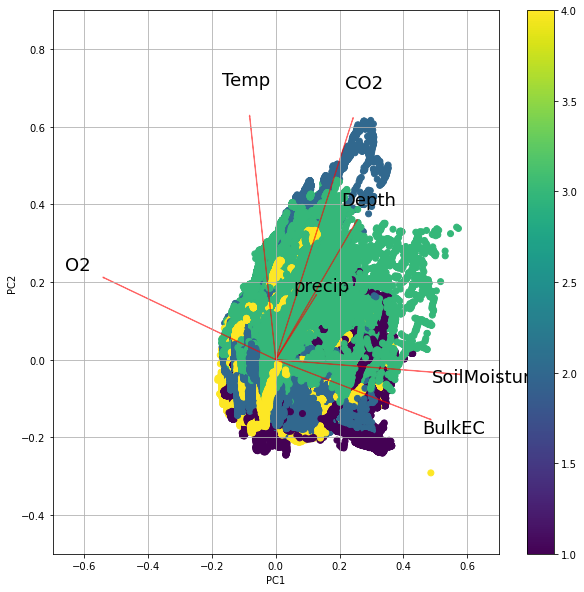

In [15]:
#PCA colored by site

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig=plt.gcf()
    plt.figure(figsize=(10,10))
    plt.scatter(xs * scalex,ys * scaley, c = df.Season[0:len(df_st)])#df_st[:,6])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df_reindex.columns.values[i], color = 'k', ha = 'center', va = 'center', fontsize=18)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

<Figure size 432x288 with 0 Axes>

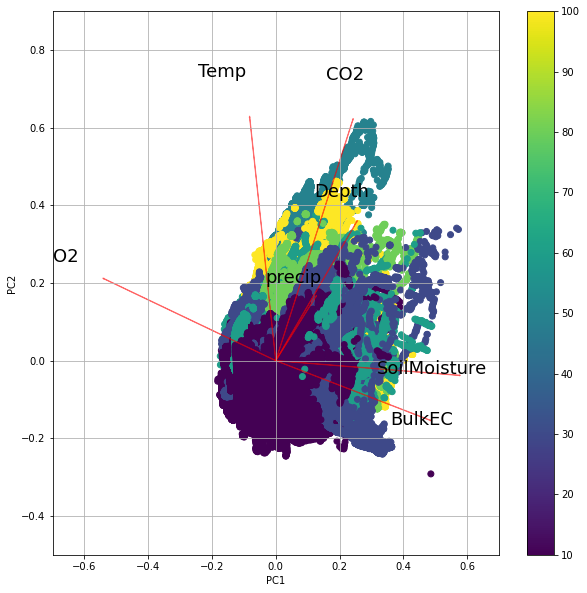

In [16]:
#PCA colored by depth

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig=plt.gcf()
    plt.figure(figsize=(10,10))
    plt.scatter(xs * scalex,ys * scaley, c = df.Depth[0:len(df_st)])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df_reindex.columns.values[i], color = 'k', ha = 'right', va = 'bottom', fontsize=18)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [9]:
#Run this for machine learning model with standardization

from sklearn.model_selection import train_test_split

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",
y=df_st1['SoilMoisture']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)

#Run this lower part of the cell to compare cross validation scores with test/train scores

#from sklearn.model_selection import cross_val_score

#print (neigh.score(X_test,y_test))
#prediction=neigh.predict(X_test)
#print(metrics.mean_squared_error(y_train, prediction, squared=False))
#scores=cross_val_score(neigh, X,y, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1)


#print (np.mean(scores))

KNeighborsRegressor(n_neighbors=2)

In [26]:
#Cross validation scores
#from joblib import parallel_backend
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

from sklearn.model_selection import cross_val_score
k_range=range(1,8)
k_scores=[]
for k in k_range:
    knn=KNeighborsRegressor(n_neighbors=k)
    scores=cross_val_score(knn, X,y, cv=5, random_state=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    k_scores.append(np.abs(scores.mean()))

SyntaxError: invalid syntax (<ipython-input-26-000568708c98>, line 11)

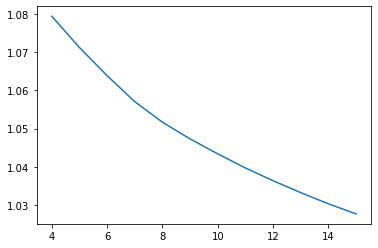

In [62]:
#import sklearn.metrics
#sklearn.metrics.SCORERS.keys()
plt.plot(k_range,k_scores)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
k_range=range(1,12)
#knn=KNeighborsRegr essor(n_neighbors=k)
param_grid=dict(n_neighbors=k_range)
cv=ShuffleSplit(n_splits=10, test_size=.2, train_size=.8, random_state=0)
grid=GridSearchCV(neigh, param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=0.8),
             estimator=KNeighborsRegressor(n_neighbors=2), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 12)},
             scoring='neg_root_mean_squared_error')

In [47]:
from sklearn import metrics

grid.cv_results_
#metrics.SCORERS.keys()
df[df.Site==0]

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
6794,13570.0,1.459382e+18,0.0,0.358,0.044,16.705,19.413019,0.0,50.0,0.0,1.0
6795,13830.0,1.459386e+18,0.0,0.358,0.044,16.770,19.417373,0.0,50.0,0.0,1.0
6796,14100.0,1.459390e+18,0.0,0.358,0.044,16.835,19.421726,0.0,50.0,0.0,1.0
6797,14315.0,1.459393e+18,0.0,0.358,0.044,16.890,19.425410,0.0,50.0,0.0,1.0
6798,14515.0,1.459397e+18,0.0,0.358,0.044,16.940,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
74854,19755.0,1.501186e+18,0.0,0.301,0.017,24.530,17.327472,3.0,50.0,0.0,3.0
74855,19805.0,1.501189e+18,0.0,0.301,0.017,24.540,17.328054,3.0,50.0,0.0,3.0
74856,19820.0,1.501193e+18,0.0,0.301,0.017,24.540,17.328054,3.0,50.0,0.0,3.0
74857,19850.0,1.501196e+18,0.0,0.301,0.017,24.540,17.328054,3.0,50.0,0.0,3.0


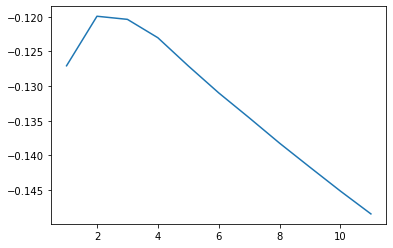

In [39]:
plt.plot(k_range,grid.cv_results_['mean_test_score'])

In [21]:
#X_original=df.iloc[y_train]
prediction=neigh.predict(X_test)
df_pred=pd.DataFrame(data=prediction)
#prediction_original_dataset=neigh.predict(X_original)


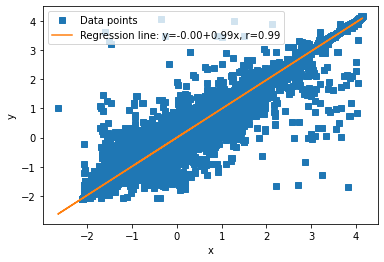

In [22]:
import scipy.stats
x=y_test
y=prediction
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [23]:
result = scipy.stats.linregress(y_test, prediction)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(y_test, prediction))
print(metrics.max_error(y_test, prediction))
print(metrics.mean_absolute_error(y_test, prediction))
print(metrics.mean_squared_error(y_test, prediction, squared=False))




0.9929375662547534
0.0
0.9903461515121792
0.0002891241064632531
0.9859024448558067
5.522471480917753
0.028961542704847968
0.11887371003456226


In [25]:
result = scipy.stats.spearmanr(y_test, prediction)
print (result.correlation)
print (result.pvalue)

r, p = scipy.stats.pearsonr(y_test, prediction)
print (r)
print (p)

result = scipy.stats.kendalltau(y_test, prediction)
print (result.correlation)
print (result.pvalue)


0.9926450152565635
0.0


In [27]:
prediction_original=prediction*np.std(df['SoilMoisture'])+np.mean(df.SoilMoisture)
y_test_original=y_test*np.std(df['SoilMoisture'])+np.mean(df.SoilMoisture)

y_hats=prediction_original
df_out = X_test.reset_index()
df_out["Actual"] = y_test_original.reset_index()['SoilMoisture']
df_out["Prediction"] = y_hats#.reset_index()[0]
y_test['preds'] = y_hats
#df_out['Depth']=df_out.Depth*np.std(df['Depth'])+np.mean(df.Depth)
df_out['CO2']=df_out['CO2']*np.std(df['CO2'])+np.mean(df.CO2)
df_out['precip']=df_out.precip*np.std(df['precip'])+np.mean(df.precip)
df_out['BulkEC']=df_out['BulkEC']*np.std(df['BulkEC'])+np.mean(df.BulkEC)
df_out['O2']=df_out.O2*np.std(df['O2'])+np.mean(df.O2)
df_out['Temp']=df_out.Temp*np.std(df['Temp'])+np.mean(df.Temp)
df_out['Site']=df_reindex.Site.loc[df_out['index']].values
df_out['timestamp']=df_reindex.timestamp.loc[df_out['index']].values
df_out['Pit']=df_reindex.Pit.loc[df_out['index']].values
df_out['Season']=df_reindex.Season.loc[df_out['index']].values
df_out['Depth']=df_reindex.Depth.loc[df_out['index']].values




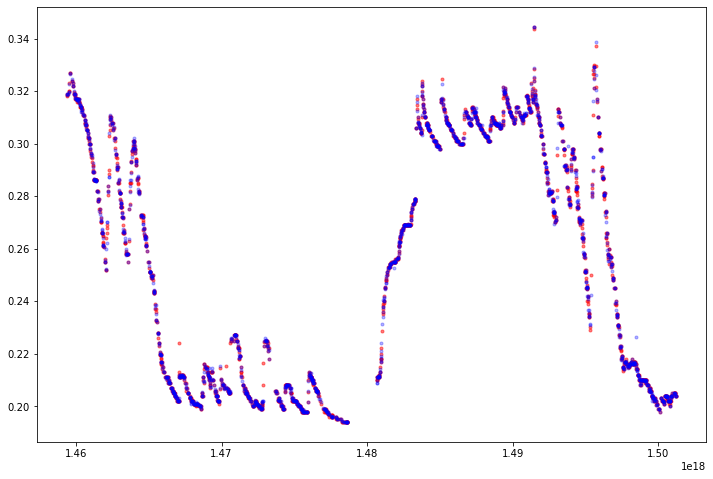

In [28]:
# Red is actual, blue is predicted
# Pit 4 (BGZOB1) is bad at 10cm and 30cm, but not too bad at 60cm. Interestingly, the model predicts the sensor error at 30cm.
# Pit 5 (BGZOB2) is much better than pit 4, but not as good as Calhoun pits. Performance is again best at 60cm.
# Weird model predictions for Pit 7 at 10cm around timestep 1.46
# Pit 9 at 30cm depth has lowest RMSE of 33
PIT=df_out.Pit==2
DEPTH=df_out.Depth==50
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.scatter(df_out.timestamp[PIT][DEPTH], df_out.Actual[PIT][DEPTH], marker='.', alpha=.5, c='r')
ax.scatter(df_out.timestamp[PIT][DEPTH], df_out.Prediction[PIT][DEPTH], marker='.', alpha=.3, c='b')
#df_out.index[df_out.Depth>=30]

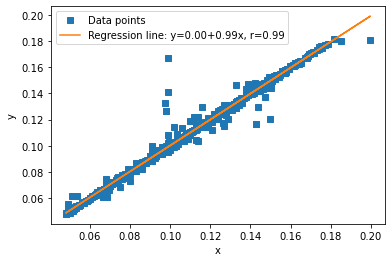

In [29]:
PIT=df_out.Pit==9
DEPTH=df_out.Depth==30
x=df_out.Actual[DEPTH][PIT]
y=df_out.Prediction[DEPTH][PIT]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [30]:

PIT=df_out.Pit==9
DEPTH=df_out.Depth==30
x=df_out.Actual[PIT][DEPTH]
y=df_out.Prediction[PIT][DEPTH]
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))
#print (r2_score(x, y))


0.06793750000001177
0.0010577439570279353
0.0037343706396092058


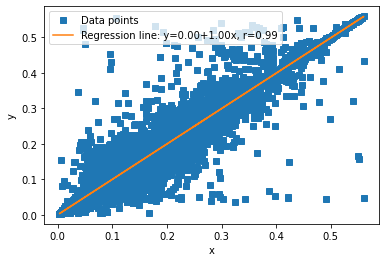

In [294]:


df_out=df_out.astype('float32')
x=df_out.Prediction
y=df_out.Actual
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [295]:
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.stderr)
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))
np.any(df_out.Depth==2)

0.9928163764856883
0.0
0.00029332390641242766
0.9855685721152401
0.51175004
0.0025791093
0.01063861


False

In [ ]:
x=df_out.Prediction[df_out.Depth==10]
y=df_out.Actual[df_out.Depth==10]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [ ]:
import scipy.stats
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))


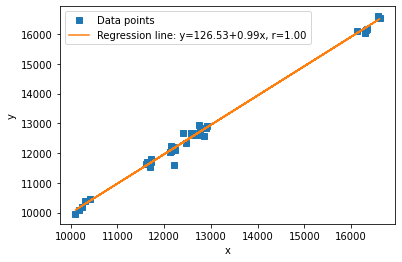

In [35]:
x=df_out.Prediction[df_out.Temp>=31.5]
y=df_out.Actual[df_out.Temp>=31.5]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [ ]:
x=df_out.Prediction[df_out.Temp<=-3]
y=df_out.Actual[df_out.Temp<=-3]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [ ]:
#Model Comparison code starts below. Only cells 1-7 (except 5) need to be run in order to start the model comparison section.

In [7]:
#Start of model comparison code

df['SoilMoisture_t_1']=df.SoilMoisture

df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season,SoilMoisture_t_1
6794,13570.00000,1.459382e+18,0.0,0.358000,0.044000,16.70500,19.413019,0.0,50.0,0.0,1.0,0.358000
6795,13830.00000,1.459386e+18,0.0,0.358000,0.044000,16.77000,19.417373,0.0,50.0,0.0,1.0,0.358000
6796,14100.00000,1.459390e+18,0.0,0.358000,0.044000,16.83500,19.421726,0.0,50.0,0.0,1.0,0.358000
6797,14315.00000,1.459393e+18,0.0,0.358000,0.044000,16.89000,19.425410,0.0,50.0,0.0,1.0,0.358000
6798,14515.00000,1.459397e+18,0.0,0.358000,0.044000,16.94000,19.428758,0.0,50.0,0.0,1.0,0.358000
...,...,...,...,...,...,...,...,...,...,...,...,...
1393070,625.05675,1.514664e+18,0.0,0.098000,0.008333,0.70850,13.778000,16.0,10.0,1.0,4.0,0.098000
1393071,620.41800,1.514668e+18,0.0,0.098000,0.010000,0.68825,13.777750,16.0,10.0,1.0,4.0,0.098000
1393072,611.34600,1.514671e+18,0.0,0.098000,0.010000,0.63875,13.780500,16.0,10.0,1.0,4.0,0.098000
1393073,607.84425,1.514675e+18,0.0,0.098000,0.010000,0.60550,13.774000,16.0,10.0,1.0,4.0,0.098000


0.04661642649111611


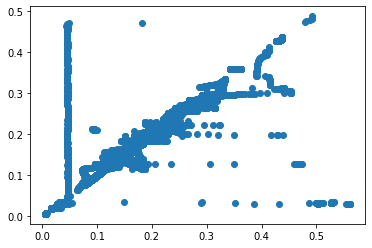

In [8]:
#Run this for systematically missing values
from sklearn import metrics

df_nan=df.copy(deep=True)
df_nan.SoilMoisture.loc[6900:7100]=np.nan
df_nan.SoilMoisture.loc[13500:13700]=np.nan
df_nan.SoilMoisture.loc[20000:20200]=np.nan
df_nan.SoilMoisture.loc[30000:30200]=np.nan
df_nan.SoilMoisture.loc[40000:40200]=np.nan
df_nan.SoilMoisture.loc[50000:50200]=np.nan
df_nan.SoilMoisture.loc[60000:60200]=np.nan
df_nan.SoilMoisture.loc[70000:70200]=np.nan
df_nan.SoilMoisture.loc[80000:80200]=np.nan
df_nan.SoilMoisture.loc[90000:90200]=np.nan
df_nan.SoilMoisture.loc[100000:100200]=np.nan
df_nan.SoilMoisture.loc[110000:110200]=np.nan
df_nan.SoilMoisture.loc[120000:120200]=np.nan
df_nan.SoilMoisture.loc[130000:130200]=np.nan
df_nan.SoilMoisture.loc[140000:140200]=np.nan
df_nan.SoilMoisture.loc[150000:150200]=np.nan
df_nan.SoilMoisture.loc[160000:160200]=np.nan
df_nan.SoilMoisture.loc[170000:170200]=np.nan
df_nan.SoilMoisture.loc[180000:180200]=np.nan
df_nan.SoilMoisture.loc[190000:190200]=np.nan
df_nan.SoilMoisture.loc[200000:200200]=np.nan
df_nan.SoilMoisture.loc[210000:210200]=np.nan
df_nan.SoilMoisture.loc[220000:220200]=np.nan
df_nan.SoilMoisture.loc[230000:230200]=np.nan
df_nan.SoilMoisture.loc[240000:240200]=np.nan
df_nan.SoilMoisture.loc[250000:250200]=np.nan
df_nan.SoilMoisture.loc[260000:260200]=np.nan
df_nan.SoilMoisture.loc[270000:270200]=np.nan
df_nan.SoilMoisture.loc[280000:280200]=np.nan
df_nan.SoilMoisture.loc[290000:290200]=np.nan
df_nan.SoilMoisture.loc[310000:310200]=np.nan
df_nan.SoilMoisture.loc[320000:320200]=np.nan
df_nan.SoilMoisture.loc[330000:330200]=np.nan
df_nan.SoilMoisture.loc[340000:340200]=np.nan
df_nan.SoilMoisture.loc[350000:350200]=np.nan
df_nan.SoilMoisture.loc[360000:360200]=np.nan
df_nan.SoilMoisture.loc[370000:370200]=np.nan
df_nan.SoilMoisture.loc[380000:380200]=np.nan
df_nan.SoilMoisture.loc[390000:390200]=np.nan
df_nan.SoilMoisture.loc[400000:400200]=np.nan
df_nan.SoilMoisture.loc[410000:410200]=np.nan
df_nan.SoilMoisture.loc[420000:420200]=np.nan
df_nan.SoilMoisture.loc[430000:430200]=np.nan
df_nan.SoilMoisture.loc[440000:440200]=np.nan
df_nan.SoilMoisture.loc[450000:450200]=np.nan
df_nan.SoilMoisture.loc[460000:460200]=np.nan
df_nan.SoilMoisture.loc[470000:470200]=np.nan
df_nan.SoilMoisture.loc[480000:480200]=np.nan
df_nan.SoilMoisture.loc[490000:490200]=np.nan
df_nan.SoilMoisture.loc[500000:500200]=np.nan
df_nan.SoilMoisture.loc[510000:510200]=np.nan
df_nan.SoilMoisture.loc[520000:520200]=np.nan
df_nan.SoilMoisture.loc[530000:530200]=np.nan
df_nan.SoilMoisture.loc[540000:540200]=np.nan
df_nan.SoilMoisture.loc[550000:550200]=np.nan
df_nan.SoilMoisture.loc[560000:560200]=np.nan
df_nan.SoilMoisture.loc[570000:570200]=np.nan
df_nan.SoilMoisture.loc[580000:580200]=np.nan
df_nan.SoilMoisture.loc[590000:590200]=np.nan
df_nan.SoilMoisture.loc[600000:600200]=np.nan
df_nan.SoilMoisture.loc[610000:610200]=np.nan
df_nan.SoilMoisture.loc[620000:620200]=np.nan
df_nan.SoilMoisture.loc[630000:630200]=np.nan
df_nan.SoilMoisture.loc[640000:640200]=np.nan
df_nan.SoilMoisture.loc[650000:650200]=np.nan
df_nan.SoilMoisture.loc[660000:660200]=np.nan
df_nan.SoilMoisture.loc[670000:670200]=np.nan
df_nan.SoilMoisture.loc[680000:680200]=np.nan
df_nan.SoilMoisture.loc[690000:690200]=np.nan
df_nan.SoilMoisture.loc[700000:700200]=np.nan
df_nan.SoilMoisture.loc[710000:710200]=np.nan
df_nan.SoilMoisture.loc[720000:720200]=np.nan
df_nan.SoilMoisture.loc[730000:730200]=np.nan
df_nan.SoilMoisture.loc[740000:740200]=np.nan
df_nan.SoilMoisture.loc[750000:750200]=np.nan
df_nan.SoilMoisture.loc[760000:760200]=np.nan
df_nan.SoilMoisture.loc[770000:770200]=np.nan
df_nan.SoilMoisture.loc[780000:780200]=np.nan
df_nan.SoilMoisture.loc[790000:790200]=np.nan
df_nan.SoilMoisture.loc[810000:810200]=np.nan
df_nan.SoilMoisture.loc[820000:820200]=np.nan
df_nan.SoilMoisture.loc[830000:830200]=np.nan
df_nan.SoilMoisture.loc[840000:840200]=np.nan
df_nan.SoilMoisture.loc[850000:850200]=np.nan
df_nan.SoilMoisture.loc[860000:860200]=np.nan
df_nan.SoilMoisture.loc[870000:870200]=np.nan
df_nan.SoilMoisture.loc[880000:880200]=np.nan
df_nan.SoilMoisture.loc[890000:890200]=np.nan
df_nan.SoilMoisture.loc[900000:900200]=np.nan
df_nan.SoilMoisture.loc[910000:910200]=np.nan
df_nan.SoilMoisture.loc[920000:920200]=np.nan
df_nan.SoilMoisture.loc[930000:930200]=np.nan
df_nan.SoilMoisture.loc[940000:940200]=np.nan
df_nan.SoilMoisture.loc[950000:950200]=np.nan
df_nan.SoilMoisture.loc[960000:960200]=np.nan
df_nan.SoilMoisture.loc[970000:970200]=np.nan
df_nan.SoilMoisture.loc[980000:980200]=np.nan
df_nan.SoilMoisture.loc[990000:990200]=np.nan
df_nan.SoilMoisture.loc[1000000:1000200]=np.nan
df_nan.SoilMoisture.loc[1010000:1010200]=np.nan
df_nan.SoilMoisture.loc[1020000:1020200]=np.nan
df_nan.SoilMoisture.loc[1030000:1030200]=np.nan
df_nan.SoilMoisture.loc[1040000:1040200]=np.nan
df_nan.SoilMoisture.loc[1050000:1050200]=np.nan
df_nan.SoilMoisture.loc[1060000:1060200]=np.nan
df_nan.SoilMoisture.loc[1070000:1070200]=np.nan
df_nan.SoilMoisture.loc[1080000:1080200]=np.nan
df_nan.SoilMoisture.loc[1090000:1090200]=np.nan
df_nan.SoilMoisture.loc[1100000:1100200]=np.nan
df_nan.SoilMoisture.loc[1110000:1110200]=np.nan
df_nan.SoilMoisture.loc[1120000:1120200]=np.nan
df_nan.SoilMoisture.loc[1130000:1130200]=np.nan
df_nan.SoilMoisture.loc[1140000:1140200]=np.nan
df_nan.SoilMoisture.loc[1150000:1150200]=np.nan
df_nan.SoilMoisture.loc[1160000:1160200]=np.nan
df_nan.SoilMoisture.loc[1170000:1170200]=np.nan
df_nan.SoilMoisture.loc[1180000:1180200]=np.nan
df_nan.SoilMoisture.loc[1190000:1190200]=np.nan
df_nan.SoilMoisture.loc[1200000:1200200]=np.nan
df_nan.SoilMoisture.loc[1210000:1210200]=np.nan
df_nan.SoilMoisture.loc[1220000:1220200]=np.nan
df_nan.SoilMoisture.loc[1230000:1230200]=np.nan
df_nan.SoilMoisture.loc[1240000:1240200]=np.nan
df_nan.SoilMoisture.loc[1250000:1250200]=np.nan
df_nan.SoilMoisture.loc[1260000:1260200]=np.nan
df_nan.SoilMoisture.loc[1270000:1270200]=np.nan
df_nan.SoilMoisture.loc[1280000:1280200]=np.nan
df_nan.SoilMoisture.loc[1290000:1290200]=np.nan
df_nan.SoilMoisture.loc[1300000:1300200]=np.nan
df_nan.SoilMoisture.loc[1310000:1310200]=np.nan
df_nan.SoilMoisture.loc[1320000:1320200]=np.nan
df_nan.SoilMoisture.loc[1330000:1330200]=np.nan
df_nan.SoilMoisture.loc[1340000:1340200]=np.nan
df_nan.SoilMoisture.loc[1350000:1350200]=np.nan
df_nan.SoilMoisture.loc[1360000:1360200]=np.nan
df_nan.SoilMoisture.loc[1370000:1370200]=np.nan
df_nan.SoilMoisture.loc[1380000:1380200]=np.nan
df_nan.SoilMoisture.loc[1390000:1390200]=np.nan
#df_nan.SoilMoisture.loc[df_nan.sample(frac=0.5).index] = np.nan



nan_index=df_nan[df_nan.SoilMoisture.notna()==False]
not_nan_index=df_nan[df_nan.SoilMoisture.notna()==True]
df_nan['SoilMoisture_t_1'].loc[nan_index.index]=np.nan
df_nan['SoilMoisture_t_1']=df_nan['SoilMoisture_t_1'].shift(1)
df_nan['SoilMoisture_t_1'][1]=.358

df_nan_linear=df_nan.copy(deep=True)
df_nan_median=df_nan.copy(deep=True)

df_nan_median.SoilMoisture=df_nan_median.SoilMoisture.fillna(np.nanmedian(df_nan_median.SoilMoisture))


df_nan_linear=df_nan_linear.interpolate()

df_nan_linear.SoilMoisture=df_nan_linear.SoilMoisture.fillna(np.nanmedian(df_nan_linear.SoilMoisture))
df_nan_linear.SoilMoisture_t_1=df_nan_linear.SoilMoisture_t_1.fillna(np.nanmedian(df_nan_linear.SoilMoisture_t_1))


print(metrics.mean_squared_error(df_nan_linear.SoilMoisture.loc[nan_index.index], df.SoilMoisture.loc[nan_index.index], squared=False))
plt.scatter(df.SoilMoisture.loc[nan_index.index], df_nan_linear.SoilMoisture.loc[nan_index.index])


0.05539637152350587


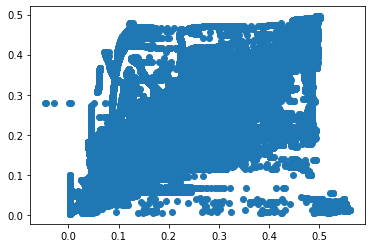

In [471]:
#Run this fo randomly missing values
from sklearn import metrics
df_nan=df.copy(deep=True)
df_nan.SoilMoisture.loc[df_nan.sample(frac=0.999).index] = np.nan


nan_index=df_nan[df_nan.SoilMoisture.notna()==False]
not_nan_index=df_nan[df_nan.SoilMoisture.notna()==True]
df_nan['SoilMoisture_t_1'].loc[nan_index.index]=np.nan
df_nan['SoilMoisture_t_1']=df_nan['SoilMoisture_t_1'].shift(1)
df_nan['SoilMoisture_t_1'][1]=.358
#not_nan_index['SoilMoisture_t_1']=not_nan_index['SoilMoisture_t_1'].shift(1)
#nan_index['SoilMoisture_t_1']=nan_index['SoilMoisture_t_1'].shift(1)
#not_nan_index['SoilMoisture_t_1']=not_nan_index['SoilMoisture_t_1'].fillna(np.nanmedian(not_nan_index['SoilMoisture_t_1']))
#nan_index['SoilMoisture_t_1']=nan_index['SoilMoisture_t_1'].fillna(np.nanmedian(nan_index['SoilMoisture_t_1']))



df_nan_linear=df_nan.copy(deep=True)
df_nan_median=df_nan.copy(deep=True)

df_nan_median.SoilMoisture=df_nan_median.SoilMoisture.fillna(np.nanmedian(df_nan_median.SoilMoisture))

df_nan_linear=df_nan_linear.interpolate()

df_nan_linear.SoilMoisture=df_nan_linear.SoilMoisture.fillna(np.nanmedian(df_nan_linear.SoilMoisture))
df_nan_linear.SoilMoisture_t_1=df_nan_linear.SoilMoisture_t_1.fillna(np.nanmedian(df_nan_linear.SoilMoisture_t_1))


print(metrics.mean_squared_error(df_nan_linear.SoilMoisture.loc[nan_index.index], df.SoilMoisture.loc[nan_index.index], squared=False))
plt.scatter(df.SoilMoisture.loc[nan_index.index], df_nan_linear.SoilMoisture.loc[nan_index.index])


In [420]:
print (df_nan.SoilMoisture.loc[nan_index.index])
print (df.SoilMoisture.loc[nan_index.index])
print (nan_index.SoilMoisture)
print (df_nan_linear.SoilMoisture.loc[nan_index.index])

print (df_nan.SoilMoisture_t_1.loc[nan_index.index])
print (df.SoilMoisture_t_1.loc[nan_index.index])
print (nan_index.SoilMoisture_t_1)
print (df_nan_linear.SoilMoisture_t_1.loc[nan_index.index])


6803      NaN
6834      NaN
6848      NaN
6858      NaN
6866      NaN
           ..
1357065   NaN
1357072   NaN
1357073   NaN
1357083   NaN
1357084   NaN
Name: SoilMoisture, Length: 83750, dtype: float64
6803       0.358000
6834       0.359000
6848       0.359000
6858       0.359000
6866       0.359500
             ...   
1357065    0.091000
1357072    0.091000
1357073    0.091167
1357083    0.095000
1357084    0.095000
Name: SoilMoisture, Length: 83750, dtype: float64
6803      NaN
6834      NaN
6848      NaN
6858      NaN
6866      NaN
           ..
1357065   NaN
1357072   NaN
1357073   NaN
1357083   NaN
1357084   NaN
Name: SoilMoisture, Length: 83750, dtype: float64
6803       0.358000
6834       0.359000
6848       0.359000
6858       0.359000
6866       0.359500
             ...   
1357065    0.091167
1357072    0.091000
1357073    0.091500
1357083    0.094778
1357084    0.094556
Name: SoilMoisture, Length: 83750, dtype: float64
6803       0.358000
6834       0.359000
6848       0

In [9]:
#Run this to train the model on whatever not_nan_index you have defined

df_st =  StandardScaler().fit_transform(df_nan_linear.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
#X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'SoilMoisture2']
X_t1=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'SoilMoisture2', 'Pit', 'Site', 'timestamp']]
y_t1=df_st1['SoilMoisture']  # Labels\n",

X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'timestamp', 'Pit', 'Site']]
y=df_st1['SoilMoisture']  # Labels\n",

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99)
X_train_t1, X_test_t1, y_train_t1, y_test_t1 = train_test_split(X_t1, y_t1, train_size=0.99)


from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
print(neigh.score(X_test,y_test))

neigh_t1 = KNeighborsRegressor(n_neighbors=2)
neigh_t1.fit(X_train_t1, y_train_t1)
print (neigh_t1.score(X_test_t1,y_test_t1))

0.9953980837727043
0.9983708684763756


In [10]:
st_nan=  StandardScaler().fit_transform(df_nan_linear.loc[nan_index.index])
df_st_nan=pd.DataFrame(data=st_nan)
df_st_nan_t1=pd.DataFrame(data=st_nan)

df_st_nan.index=nan_index.index
df_st_nan_t1.index=nan_index.index


df_st_nan.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'SoilMoisture_t_1']
X_nan=df_st_nan[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'timestamp', 'Pit', 'Site']]  # Features\n",
y_nan=df_st_nan['SoilMoisture']  # Labels\n",

df_st_nan_t1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'SoilMoisture_t_1']
#df_st_nan_t1['SoilMoisture_t_1']=df_st_nan_t1['SoilMoisture_t_1'].fillna(np.nanmedian(df_st_nan_t1['SoilMoisture_t_1']))
X_nan_t1=df_st_nan_t1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth', 'SoilMoisture_t_1', 'Pit', 'Site', 'timestamp']]  # Features\n",
y_nan_t1=df_st_nan_t1['SoilMoisture']  # Labels\n",
X_nan_t1['SoilMoisture_t_1']=X_nan_t1['SoilMoisture_t_1'].fillna(np.nanmedian(df_nan_linear['SoilMoisture_t_1']))
SM_predict=neigh.predict(X_nan)
SM_predict_df=pd.DataFrame(data=SM_predict)
SM_predict_df.index=nan_index.index

SM_predict_t1=neigh_t1.predict(X_nan_t1)
SM_predict_t1_df=pd.DataFrame(data=SM_predict_t1)
SM_predict_t1_df.index=nan_index.index



<ipython-input-10-cb3e3100fbd5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nan_t1['SoilMoisture_t_1']=X_nan_t1['SoilMoisture_t_1'].fillna(np.nanmedian(df_nan_linear['SoilMoisture_t_1']))


In [11]:
SM_predict_original=SM_predict_df*np.std(df_nan_linear['SoilMoisture'])+np.mean(df_nan_linear.SoilMoisture)

SM_predict_original_t1=SM_predict_t1_df*np.std(df_nan_linear['SoilMoisture'])+np.mean(df_nan_linear.SoilMoisture)
nan_index
df_nan_linear['SoilMoisture'].loc[nan_index.index]

6900       0.359995
6901       0.359990
6902       0.359985
6903       0.359980
6904       0.359975
             ...   
1390196    0.180421
1390197    0.180337
1390198    0.180252
1390199    0.180168
1390200    0.180084
Name: SoilMoisture, Length: 17417, dtype: float64

In [12]:
a=df.SoilMoisture.loc[nan_index.index]
b=SM_predict_original
c=SM_predict_original_t1
d=df_nan_linear.SoilMoisture.loc[nan_index.index]
e=df_nan_median.SoilMoisture.loc[nan_index.index]
print(metrics.mean_squared_error(df_nan_linear.SoilMoisture.loc[nan_index.index], df.SoilMoisture.loc[nan_index.index], squared=False))

print('kNN without lag RMSE:',metrics.mean_squared_error(a, b, squared=False))
print('kNN with lag RMSE:', metrics.mean_squared_error(a, c, squared=False))
print('Linear RMSE:', metrics.mean_squared_error(a, d, squared=False))
print('Median RMSE:', metrics.mean_squared_error(a, e, squared=False))


print(metrics.max_error(a, b))
print(metrics.max_error(a, c))
print(metrics.max_error(a, d))

print(metrics.mean_absolute_error(a, b))
print(metrics.mean_absolute_error(a, c))
print(metrics.mean_absolute_error(a, d))
print(metrics.mean_absolute_error(a, e))



print(np.var(df.SoilMoisture))





0.04661642649111611
kNN without lag RMSE: 0.03749318365059663
kNN with lag RMSE: 0.04484739590068327
Linear RMSE: 0.04661642649111611
Median RMSE: 0.086835014860258
0.5365402838991181
0.5365402838991181
0.5300050000000001
0.01499532025792902
0.013317815005372826
0.011074529598871067
0.06714018391992499
0.007892823381031958


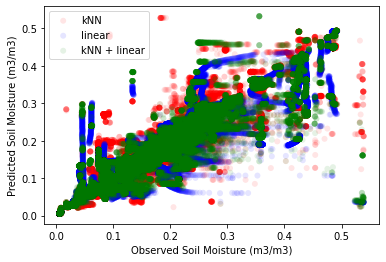

In [18]:
#print(metrics.mean_squared_error(ab, bc, squared=False))
#plt.scatter(a, b)


fig, ax = plt.subplots()

ax.scatter(a, b, c='r', label='kNN',
               alpha=0.1, edgecolors='none')

ax.scatter(a, d, c='b', label='linear',
               alpha=0.1, edgecolors='none')
ax.scatter(a, c, c='g', label='kNN + linear',
               alpha=0.1, edgecolors='none')
#ax.scatter(a, e, c='g', label='kNN with lag',
               #alpha=0.3, edgecolors='none')
ax.legend(loc=2)
ax.set_xlabel('Observed Soil Moisture (m3/m3)')
ax.set_ylabel('Predicted Soil Moisture (m3/m3)')
#ax.set_title('Observed vs predicted soil moi')
plt.show()
#plt.scatter(a,d)
#plt.scatter(a,c)
#plt.scatter(a,b)

0.3000129857327075
0.0
0.08900602673641443
0.0008857927513037955


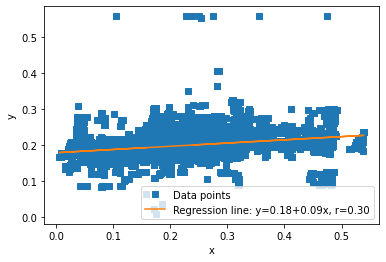

In [49]:
import scipy.stats
x=a
y=c[0]
result = scipy.stats.linregress(x, y)

from sklearn.metrics import r2_score
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)

slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [462]:
import hydroeval as he


print( he.evaluator(he.nse, a, b))
print( he.evaluator(he.nse, a, c))
print( he.evaluator(he.nse, a, d))




[0.86819213]
[0.89447222]
[0.90385707]


In [18]:
from sklearn.metrics import r2_score
print (r2_score(a, b))
print (r2_score(a, c))
print (r2_score(a, d))
nan_index

0.9026996393540871
0.9372853402594189
0.9560175266603729


,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season,SoilMoisture_t_1
13500,3640.00000,1.483524e+18,12.37,NaN,0.058000,12.10000,18.217410,0.0,50.0,0.0,1.0,0.413
13501,3750.00000,1.483528e+18,12.37,NaN,0.058000,12.11000,18.213699,0.0,50.0,0.0,1.0,0.413
13502,3690.00000,1.483531e+18,0.00,NaN,0.058000,12.11000,18.213699,0.0,50.0,0.0,1.0,0.413
13503,3610.00000,1.483535e+18,0.00,NaN,0.058000,12.10000,18.208712,0.0,50.0,0.0,1.0,0.413
13504,3685.00000,1.483538e+18,0.00,NaN,0.058000,12.10000,18.208712,0.0,50.0,0.0,1.0,0.413
...,...,...,...,...,...,...,...,...,...,...,...,...
1350196,1425.55650,1.489788e+18,0.00,NaN,0.031667,1.36200,13.886000,16.0,10.0,1.0,1.0,0.199
1350197,1403.00100,1.489792e+18,0.00,NaN,0.033333,1.35850,13.886500,16.0,10.0,1.0,1.0,0.199
1350198,1369.57675,1.489795e+18,0.00,NaN,0.033333,1.34450,13.887750,16.0,10.0,1.0,1.0,0.198
1350199,1373.58200,1.489799e+18,0.00,NaN,0.030000,1.33075,13.889500,16.0,10.0,1.0,1.0,0.198


In [19]:
len(nan_index)/len(df)

0.01983044776119403

In [140]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df_imputed=imputer.fit_transform(df_nan)

KeyboardInterrupt: 

In [590]:
imputed=pd.DataFrame(data=df_imputed)
imputed[3]
print('kNN without lag RMSE:',metrics.mean_squared_error(a, b, squared=False))


0         0.35800
1         0.33350
2         0.33375
3         0.35800
4         0.35800
           ...   
837495    0.17800
837496    0.26450
837497    0.17750
837498    0.17700
837499    0.17640
Name: 3, Length: 837500, dtype: float64

In [608]:
a
imputed.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season', 'SoilMoisture_t_1']
imputed.index=df.index
e=imputed.SoilMoisture.loc[nan_index.index]


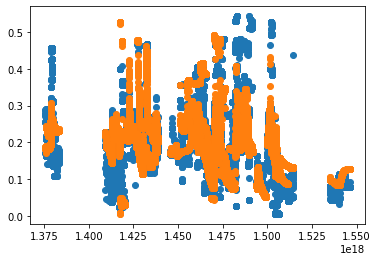

In [169]:
plt.scatter(nan_index.timestamp,b)
plt.scatter(nan_index.timestamp,nan_index.SoilMoisture_t_1)